<h1 style="color:rgb(0,120,170)">CharRNN (using PyTorch)</h1>



In this notebook I will implement RNN using Pytorch

The assignment is the (maybe famous) CharRNN described in e.g. this [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy. CharRNN stands for "Character RNN", because we train the recurrent neural network, an LSTM in this case, to predict the next character of an input sequence. Once the model is trained, we can use it go generate text by iteratively predicting the next character and then feeding this character back into the model as input for the next position. 

- We will use "real" data to train our model.
- We will use the model for a classification task (predict the next character), which will require a different loss function.


Tasks
- Implementing a PyTorch Dataset class to load, preprocess and return text data.
- Implement your own LSTM as a PyTorch Module
- Implement everything required for training your model and then use this code to actually train your model.
- Visualize the training progress
- Generate text

Useful links:
- [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) Introduction to PyTorch
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)


In [1]:
import re
from pathlib import Path, PosixPath
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multinomial import Multinomial
import torch.optim as optim





print('python version: 3.9.12')
print('numpy version:',np.__version__)
print('matplotlib version:',matplotlib.__version__)
print('pytorch version:',torch.__version__)

python version: 3.9.12
numpy version: 1.21.5
matplotlib version: 3.5.1
pytorch version: 1.13.0


<h2 style="color:rgb(0,120,170)">Task 1: PyTorch Dataset</h2>

Using PyTorch, data loading and preprocessing is done in so called [`Dataset`](https://pytorch.org/docs/stable/data.html) classes. The rules are:
- The class has to inherit from PyTorch's Dataset class (`from torch.utils.data import Dataset`)
- The class has to return the total number of samples in the `__len__(self)` method
- The class has to return sample `idx` in the method `__getitem__(self, idx: int)`

You can add any other functionality required to this class that is needed for e.g. loading your data into memory and preprocessing your data, but these three points are a must. If you follow these requirements, however, you can make use of PyTorchs `DataLoader` class, which automatically combines random samples into minibatches and out-sources data loading/preprocessing to parallel threads and does not block the model training.

In [2]:
class TextDS(Dataset):
    def __init__(self, text_file: PosixPath, seq_length: int):
        #defined by user
        self.path = Path('.')/text_file
        self.seq_length = seq_length
        
        #text data
        self.text = None
        self.vocab = None 
        self.char2idx = None
        self.idx2char = None
        self.seq_length = seq_length
        
        #datasets
        self.samples = []
        self.input_dataset = None
        self.target_dataset = None
        
        #initialization of dataset
        self.init_dataset()
        
        
            
            
            
    def init_dataset(self):
        #text loading and cleaning
        text = '' 
        utf8_apostrophe = b'\xe2\x80\x99'.decode("utf8") 
        string_apostrophe = "'" 
        with open(self.path,encoding="utf8") as f: 
            for line in f: 
                line = re.sub(utf8_apostrophe, string_apostrophe, line) 
                line = re.sub("‘", "", line) 
                text += self.subst(line.strip('\n').lower()) 

        text = re.sub('speech [0-9]', '', text) 
        self.text = text[1:]
        
        
        #vocab and dataset
        self.vocab = sorted(set(self.text)) 
        self.char2idx = {u:i for i, u in enumerate(self.vocab)} 
        self.idx2char = {i:u for i, u in enumerate(self.vocab)}
        
        #creating datasets:
        text_int = np.array([self.char2idx[c] for c in self.text])
        examples_per_epoch = len(text_int)//(self.seq_length - 1)

        input_dataset = torch.from_numpy(text_int[:-1])
        target_dataset = torch.from_numpy(text_int[1:])

        self.input_dataset = torch.chunk(input_dataset,examples_per_epoch)[:-1]
        self.target_dataset = torch.chunk(target_dataset,examples_per_epoch)[:-1]

        for i in range(len(self.input_dataset)):
            self.samples.append((self.input_dataset[i],self.target_dataset[i]))
        


        
    def __len__(self) -> int:
        return len(self.samples)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.samples[idx]
        
        
        
        
    
    def to_int(self,char):
        #text to integers:
        return self.char2idx[char] 

    
    def to_char(self,integer):
        #integers to text
        return self.idx2char[integer] 
 




    def subst(self,phrase): 
        #takes care of short forms 
        phrase = re.sub(r"won't", "will not", phrase) 
        phrase = re.sub(r"can't", "cannot", phrase) 
        phrase = re.sub(r"n\'t", " not", phrase) 
        phrase = re.sub(r"\'re", " are", phrase) 
        phrase = re.sub(r"\'s", " is", phrase) 
        phrase = re.sub(r"\'d", " would", phrase) 
        phrase = re.sub(r"\'ll", " will", phrase) 
        phrase = re.sub(r"\'t", " not", phrase) 
        phrase = re.sub(r"\'ve", " have", phrase) 
        phrase = re.sub(r"\'m", " am", phrase) 
        phrase = re.sub(r"\'cause", " because", phrase) 
        phrase = re.sub(r"\‘cause", " because", phrase) 

        #takes care of unecessary signs for text generation    
        phrase = re.sub(r"é", "e", phrase) 
        phrase = re.sub(r"=", "", phrase) 
        phrase = re.sub(r"_", "", phrase) 
        phrase = re.sub(r"[\(\[].*?[\)\]]", "", phrase) 
        phrase = re.sub(r'“', '', phrase) 
        phrase = re.sub(r'”', '', phrase) 
        phrase = re.sub(r'"', '', phrase)  
        phrase = re.sub(r'/', '', phrase) 
        phrase = re.sub(r"@realdonaldtrump.", "", phrase) 
        phrase = re.sub(r"q&a", "", phrase) 
        phrase = re.sub(r"…", ",", phrase) 
        phrase = re.sub(r"\.{3}", ",", phrase) 
        phrase = re.sub(r"—", ",", phrase) 
        phrase = re.sub(r"–", ",", phrase) 
        phrase = re.sub(r"%", "", phrase)

        phrase = re.sub(r"--", " ", phrase)  
        phrase = re.sub(r"-", "", phrase) 
        #To ease punctuation: 
        phrase = re.sub(r";", ",", phrase) 
        phrase = re.sub(r"!", ".", phrase)  


        return phrase


        

In [3]:
batch_size = 64
dataset_train = TextDS('trump_train.txt', 150)
dataloader_train  = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test = TextDS('trump_val.txt', 150)
dataloader_test  = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

<h2 style="color:rgb(0,120,170)">Task 2: PyTorch Model</h2>

In the next step, I will implement the LSTM as a PyTorch Module. 

Implementing a model in PyTorch has to follow these rules:
- Your model class has to inherit from the `nn.Module` class (`import torch.nn as nn`)
- You have to implement at least the `__init__()` and `forward()` method.
    - The `__init__()` method is where you usually allocate the required network parameters (stored as class attributes).
    - The `forward()` method implements the entire forward-pass through your model, from inputs to model predictions.
    


In [4]:
class Model(nn.Module):
    def __init__(self, input_size,hidden_size,output_size,batch_size):
        super(Model, self).__init__()
        #Parameters for weights:
        self.input = input_size
        self.hidden = hidden_size
        self.output = output_size
        self.batch_size = batch_size
        
        ###Weights###
        #Input weights:
        self.W_input = nn.Parameter(torch.Tensor(self.input,self.hidden))
        self.R_input = nn.Parameter(torch.Tensor(self.hidden,self.hidden))
        self.b_input = nn.Parameter(torch.Tensor(self.hidden))
        
        #Output weights:
        self.W_output = nn.Parameter(torch.Tensor(self.input,self.hidden))
        self.R_output = nn.Parameter(torch.Tensor(self.hidden,self.hidden))
        self.b_output = nn.Parameter(torch.Tensor(self.hidden))
        
        #Forget weights:
        self.W_forget = nn.Parameter(torch.Tensor(self.input,self.hidden))
        self.R_forget = nn.Parameter(torch.Tensor(self.hidden,self.hidden))
        self.b_forget = nn.Parameter(torch.Tensor(self.hidden))
        
        #New Cell wights:
        self.W_cell = nn.Parameter(torch.Tensor(self.input,self.hidden))
        self.R_cell = nn.Parameter(torch.Tensor(self.hidden,self.hidden))
        self.b_cell = nn.Parameter(torch.Tensor(self.hidden))
        
        #Linear weights for prediction:
        self.W_pred = nn.Parameter(torch.Tensor(self.hidden,self.output))
        self.b_pred = nn.Parameter(torch.Tensor(self.output))
        
        #Embedding:
        self.emb = nn.Embedding(num_embeddings = self.output, embedding_dim =  self.input)
        
        #Softmax:
        self.Softmax = nn.Softmax(dim = 1)
        
        
        
        #Weights initialization:
        self.weight_init()
        
        
    def weight_init(self):
        for p in self.parameters():
            if len(p.shape)>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x):
        
        logits_batch = []
        prediction_batch = []
        
        #cell staste and hidden state:
        self.c_t = torch.zeros(x.shape[0],self.hidden)
        self.h_t = torch.zeros(x.shape[0],self.hidden)
        
        embeddings = self.emb(x)
        
        for i in range(embeddings.shape[1]): 
            x_t = embeddings[:,i,:]
            
            input_gate = torch.sigmoid(x_t @ self.W_input + self.h_t @ self.R_input + self.b_input)
            output_gate = torch.sigmoid(x_t @ self.W_output + self.h_t @ self.R_output + self.b_output)
            forget_gate = torch.sigmoid(x_t @ self.W_forget + self.h_t @ self.R_forget + self.b_forget)
            cell_gate = torch.tanh(x_t @ self.W_cell + self.h_t @ self.R_cell + self.b_cell)
            
            self.c_t = forget_gate * self.c_t + input_gate * cell_gate
            self.h_t = output_gate * torch.tanh(self.c_t)
            
            logits = self.h_t @ self.W_pred + self.b_pred
            probs = self.Softmax(self.h_t @ self.W_pred + self.b_pred)
            
            pred = torch.argmax(probs,dim = 1)
            pred = pred.unsqueeze(1)
            
            prediction_batch.append(pred)
            logits_batch.append(logits)
            
        
        prediction_batch = torch.stack(prediction_batch,dim = 1)
        prediction_batch = prediction_batch.squeeze(2)

        logits_batch = torch.stack(logits_batch,dim = 1)
        logits_batch = torch.transpose(logits_batch,1,2)

        return logits_batch,prediction_batch
    
    def predict(self,x):
        
        embeddings = self.emb(x)
        for i in range(embeddings.shape[1]): 

            x_t = embeddings[:,i,:]
            
            input_gate = torch.sigmoid(x_t @ self.W_input + self.h_t @ self.R_input + self.b_input)
            output_gate = torch.sigmoid(x_t @ self.W_output + self.h_t @ self.R_output + self.b_output)
            forget_gate = torch.sigmoid(x_t @ self.W_forget + self.h_t @ self.R_forget + self.b_forget)
            cell_gate = torch.tanh(x_t @ self.W_cell + self.h_t @ self.R_cell + self.b_cell)
            
            self.c_t = forget_gate * self.c_t + input_gate * cell_gate
            self.h_t = output_gate * torch.tanh(self.c_t)
            
            if i == embeddings.shape[1] - 1:
                probs = self.Softmax(self.h_t @ self.W_pred + self.b_pred)
                return probs
        
        
    def reset_hidden(self,batch_size):
        self.c_t = torch.zeros(batch_size,self.hidden)
        self.h_t = torch.zeros(batch_size,self.hidden)

<h2 style="color:rgb(0,120,170)">Task 3: Model training and validation</h2>


In [ ]:
def train(model,train_loader, optimizer, epoch):
    model.train()
    loss_overall_train = 0.0
    loss_plot = 0.0
    
    #training:
    for i, (inputs_train,targets_train) in enumerate(train_loader):
        optimizer.zero_grad()

        logits_train,pred_train = model.forward(inputs_train)
        loss_train = criterion(logits_train, targets_train)
        loss_train.backward()
        optimizer.step()
        
        loss_overall_train += loss_train.item()
        loss_plot += loss_train.item()
        accuracy_train = torch.sum(pred_train == targets_train)/(targets_train.shape[0] * targets_train.shape[1])
        
        if i % 10 == 9:
            print('[%d, %5d] Loss Train: %.3f' %(epoch + 1, i + 1, loss_overall_train / 10))
            print('[%d, %5d] Accuracy Train: %.2f' % (epoch + 1, i + 1,accuracy_train * 100) + '%')
            print('----------------------------') 
            loss_overall_train = 0.0
    
    return loss_plot / (i + 1)


def test(model, test_loader):
    model.eval()
    loss_overall_test = 0.0
    
    with torch.no_grad():
        for i, (inputs_test,targets_test) in enumerate(test_loader):

            logits_test,pred_test = model.forward(inputs_test)
            loss_test = criterion(logits_test, targets_test)

            loss_overall_test += loss_test.item()
            accuracy_test = torch.sum(pred_test == targets_test)/(targets_test.shape[0] * targets_test.shape[1])

            
    print('[%d] Loss Test: %.3f' %(epoch + 1, loss_overall_test / (i + 1)))
    print('[%d] Accuracy Test: %.2f' % (epoch + 1,accuracy_test * 100) + '%')
    print('EPOCH [%d] is completed!'% (epoch + 1))
    print('----------------------------')
    return loss_overall_test / (i + 1)


model = Model(input_size = 256,hidden_size = 512,output_size = len(dataset_train.vocab),batch_size = batch_size)

EPOCH = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

loss_train = []
loss_test = []

for epoch in range(EPOCH):
    loss_train.append(train(model,dataloader_train,optimizer,epoch))
    loss_test.append(test(model,dataloader_test))
    



<h2 style="color:rgb(0,120,170)">Excercise 4: Visualize the training progress</h2>

Create visualization(s) showing the training and validation loss over the course of the model training and write a short figure caption to explain your plot(s).

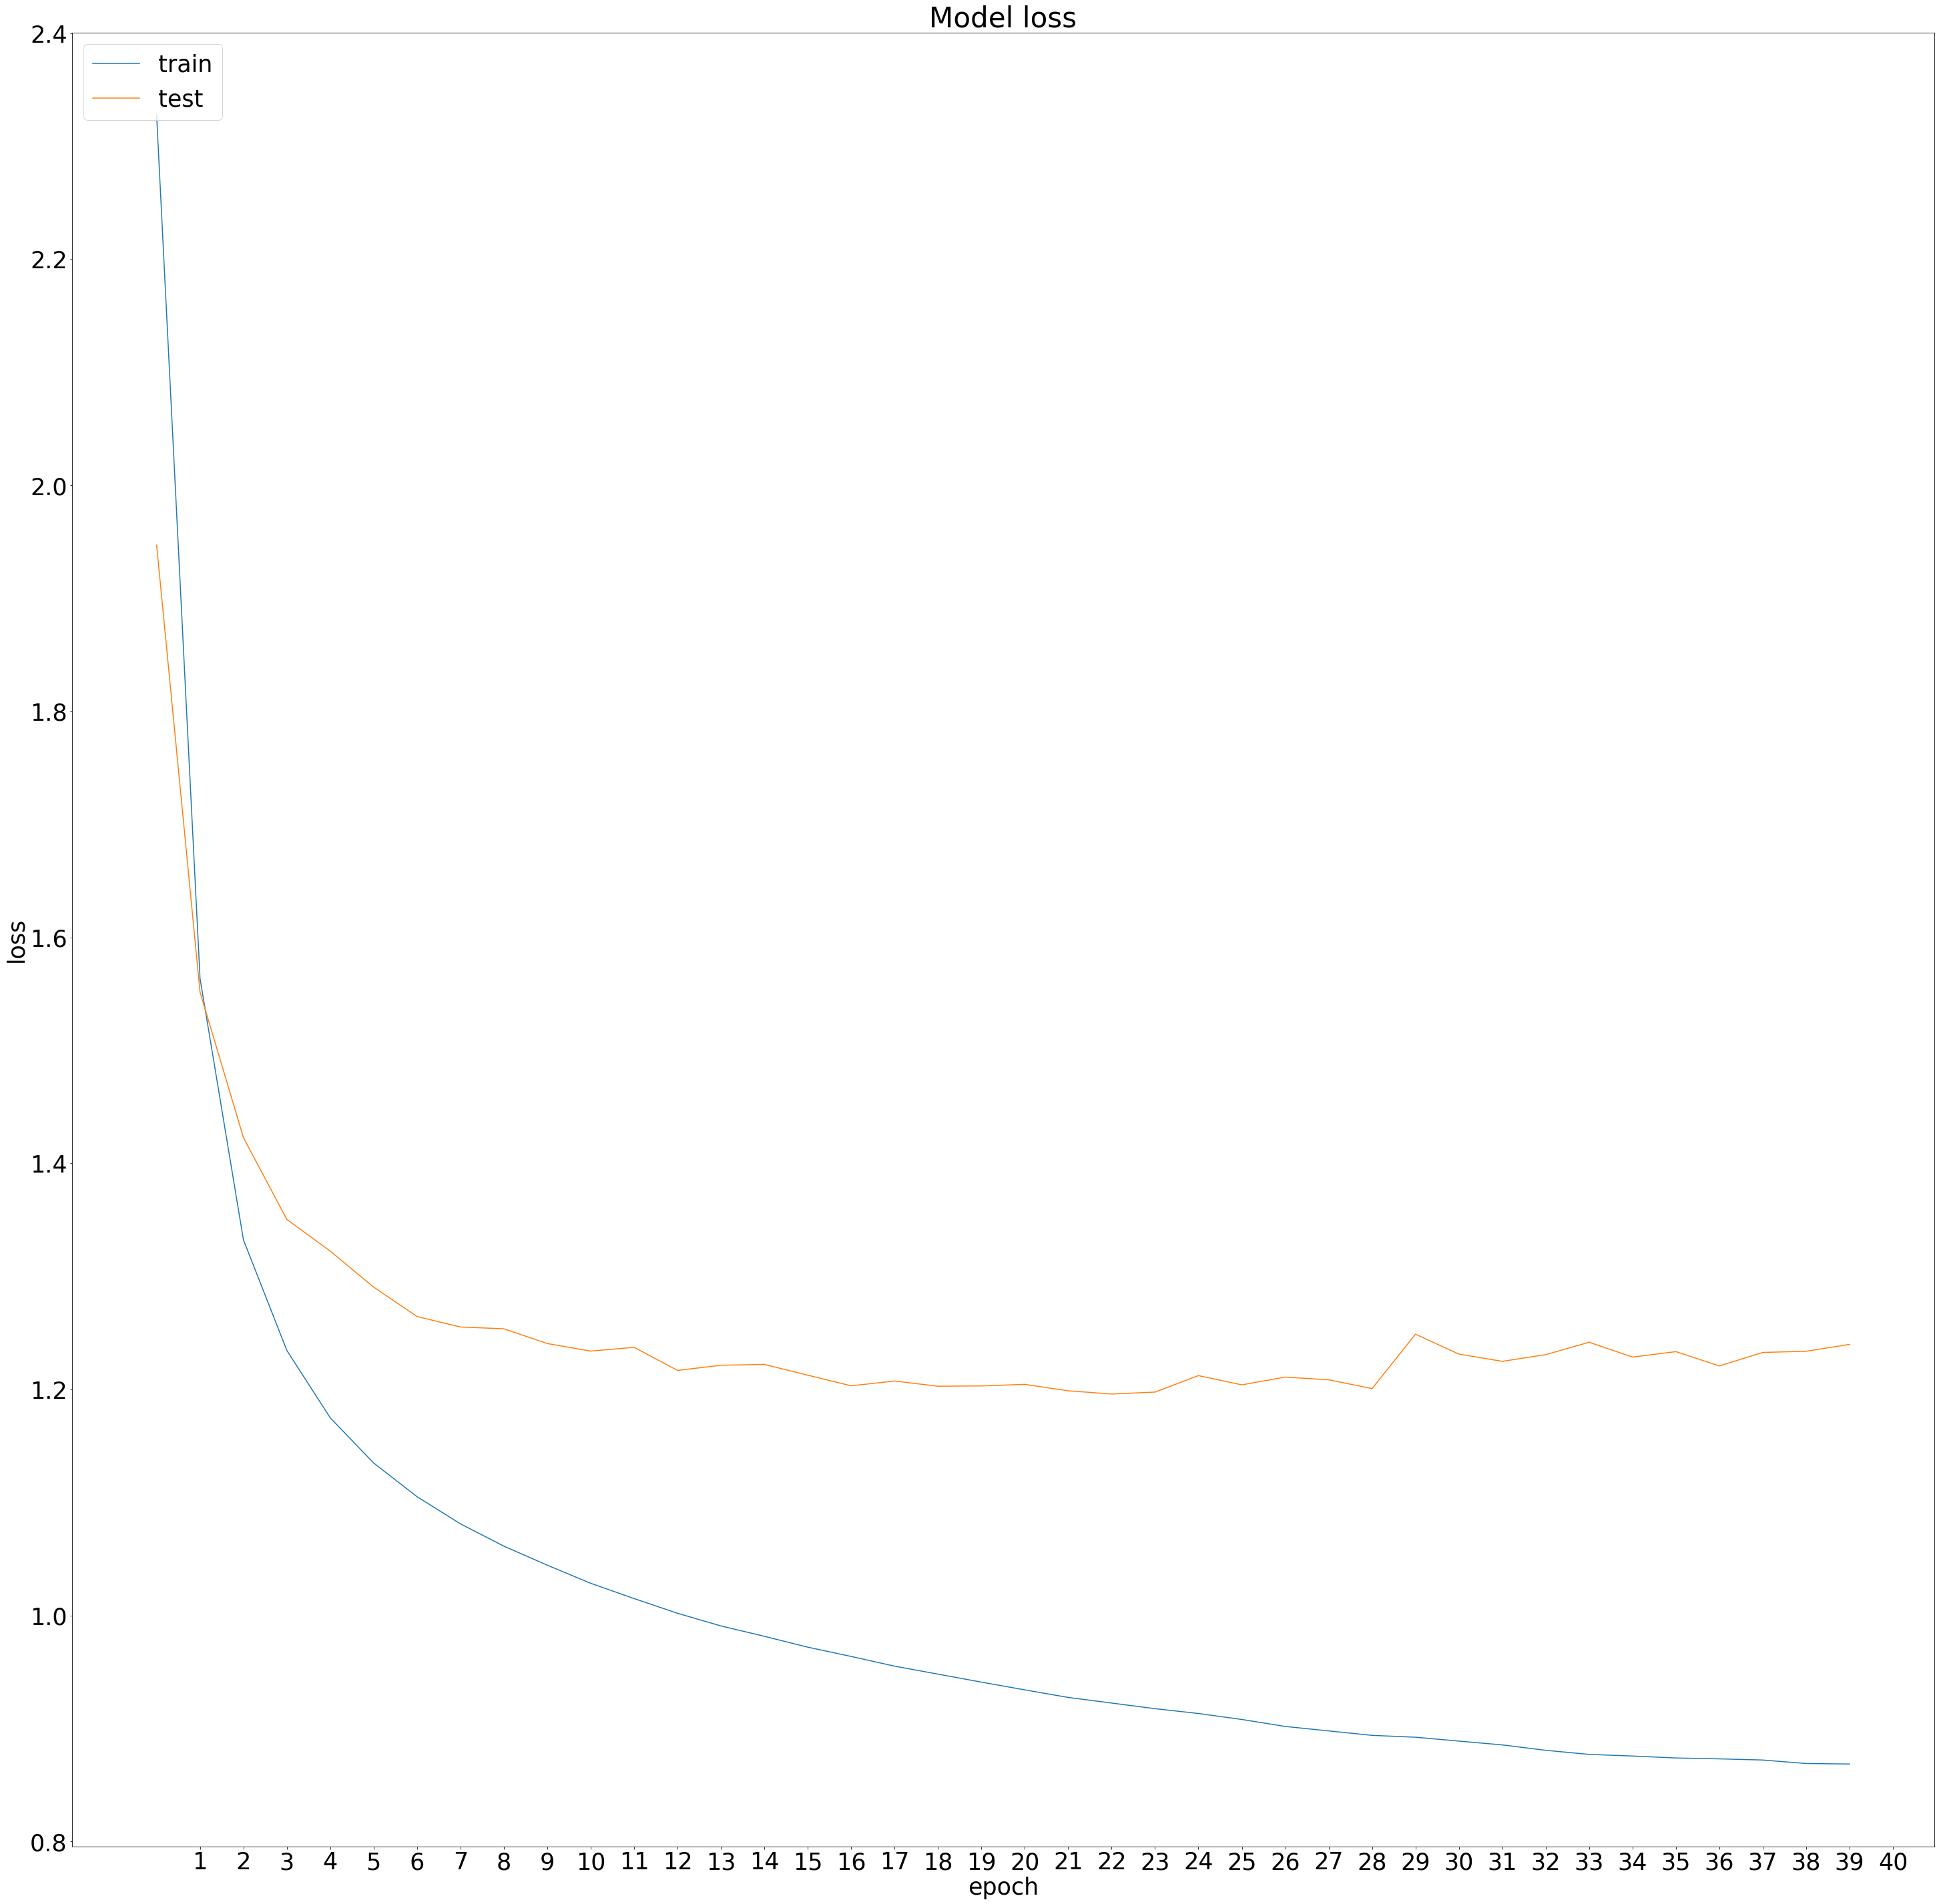

In [68]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.rcParams["figure.figsize"]=50,50
plt.rcParams.update({'font.size': 35})
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(1, EPOCH + 1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2 style="color:rgb(0,120,170)">Task 5: Generate text</h2>

Now that you have a trained CharRNN, go on and generate some text. Therefore, start of with some initial text string you provide the model as the initial text and then predict character by character, always adding the previous predicted character to the input sequence for the next character.


In [79]:
def generate_text(model, input_string ,num_char = 50,top_k = 1):
    num_string = np.array([dataset_test.to_int(x) for x in input_string.lower()])
    tensor_string = torch.from_numpy(num_string).unsqueeze(0)
    model.eval()
    generated_text = []
    
    model.reset_hidden(1)
        
    for i in range(num_char):
        probs = model.predict(tensor_string)
        probs = probs.squeeze(0)
        
        mult_distr = Multinomial(total_count = 50,probs = probs)
        mult_distr_sample = mult_distr.sample()
        
        indices = torch.topk(mult_distr_sample,k = top_k).indices #selects top_k classes with highest probability
        rd = np.random.randint(low = 0,high = top_k, size = 1)
        idx = indices[rd].unsqueeze(1)
        
        tensor_string = torch.cat((tensor_string,idx),dim = 1)        
        generated_text.append(dataset_test.to_char(indices[rd].numpy()[0]))
        
    return (input_string + ''.join(generated_text))
    

In [16]:
text = generate_text(model,'i want to make america',num_char = 200,top_k = 1)
text

'i want to make america great again. we are going to renegotiate. they have to get the dollars. he is going to be representing with the media started because we have got to be tough to the end of this country. they do not h'

In [80]:
text_2 = generate_text(model,'i like',num_char = 200,top_k = 1)
text_2

'i like the people in the world. and then i said to my office. they are going to do the first thing that i have ever seen that is a big deal that i have ever seen anything like that. we are going to have a b'